# Facial Expression Recoginition

Facial Expression Recognition is the process of identifying human emotion through analyzing face expression. 
Our aim is to identify the human facial expression by analyzing its images.

For our Case study, we have been provided Train image dataset and labels dataset ,both have 9328 rows.This two datasets is used to train our model. Other than this two datasets, we have been given Public test image set and Private test image data set that we had used to test our our data.

Since, this project is on Kaggle Competition so , we have provided Public test data in which we have to test our model and update it on the Kaggle. Now, we will load all the library that will be used in our project.

In [1]:
# some initialisation code
import numpy as np # to store the image into the numpy array
import pandas as pd #to store the data in the dataframe
import matplotlib.pyplot as plt # to plot the data i.e. to show the images in the data
import tensorflow as tf #tensorflow is used to apply CNN model 
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier

from sklearn import svm
import keras #it is used to implement deep learning model

from matplotlib.pyplot import imshow #imshow to display the image of the data
from sklearn.model_selection import train_test_split # split the data into training and testing
from sklearn.metrics import accuracy_score #to calculate the accuracy
from keras.models import Sequential #A Sequential model where each layer has exactly one input tensor and one output tensor
from keras.layers import Dense, Dropout, Flatten, Activation 
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model #Create the model
import keras.backend as K
from keras.layers.normalization import BatchNormalization # it is used to normalized the data
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model
from IPython.display import Image


from PIL import Image
from skimage.transform import resize #for resize the image

Using TensorFlow backend.


# Resource required for models

Conventional Machine learning Training was done on Google colab and on 15GPU, but the deep learning training is done amazon saze maker as the Kernel got crashed when anything bigger than 15 GPU run on colab due to this amazonsazemaker is used

If your system have high graphics card then there is no need to develop the model on colab or amazonsaze maker, model can easily be created on the local system.

We upload the file on the Amazonsaze maker. Amazonmaker has S3 bucket which is repository of data, so we used that and upload our data files on it.

In [2]:
from s3fs.core import S3FileSystem #to upload the file on the sazemaker
s3 = S3FileSystem() 

image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral']#load the emotions label into the list

key_train = 'Training_data_images.npy' #store the filename in the variables
key_test = 'PrivateTest_data_images.npy'
key_test1='PublicTest_data_images.npy'
key_label = 'Training_data_labels.npy'
bucket = 'mlproject-major/facial-expression-recognition'

images_train = np.load(s3.open('{}/{}'.format(bucket, key_train)))#bucket contains the files, so np load the file from S3 bucket
labels_train =  np.load(s3.open('{}/{}'.format(bucket, key_label)))

images_test_public=np.load(s3.open('{}/{}'.format(bucket, key_test1)))

images_test_private = np.load(s3.open('{}/{}'.format(bucket, key_test)))


print(images_train.shape)
print(labels_train.shape)
print(images_test_public.shape)
print(images_test_private.shape)

(9328, 48, 48)
(9328,)
(1136, 48, 48)
(1153, 48, 48)


In [3]:
sample_image = 10
print(images_train[sample_image])
print(labels_train[sample_image])
print(EMOTIONS[labels_train[sample_image]])

[[0.78431373 0.78431373 0.78431373 ... 0.78431373 0.78431373 0.78431373]
 [0.78431373 0.78431373 0.78431373 ... 0.78431373 0.78431373 0.78431373]
 [0.78431373 0.78431373 0.78431373 ... 0.78431373 0.78431373 0.78431373]
 ...
 [0.78431373 0.78431373 0.78431373 ... 0.37254902 0.29411765 0.76078431]
 [0.78431373 0.78431373 0.78431373 ... 0.36862745 0.30980392 0.76078431]
 [0.78431373 0.78431373 0.78431373 ... 0.4        0.35686275 0.76470588]]
6
neutral


Now we will see the Graphical representation of the data, we can see some sample faces from the Train and Test data in the greyscale format. We are displaying 25 sample images to examine the expression, face features and imagesize. 

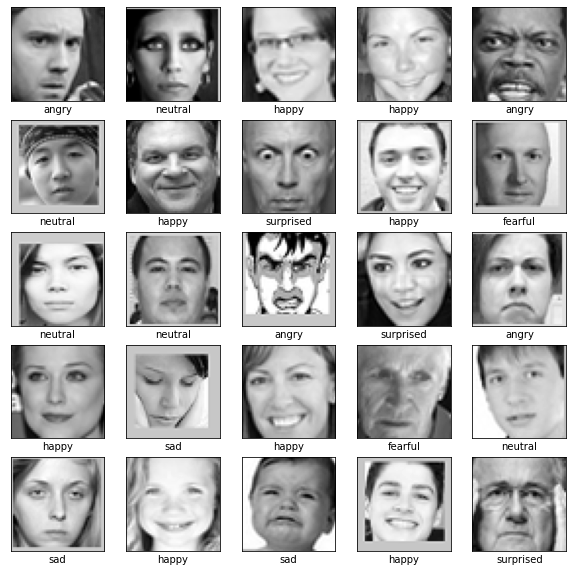

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel(EMOTIONS[ labels_train[i] ] )
plt.show()

Now we will display some images of the test data to analyze their features.

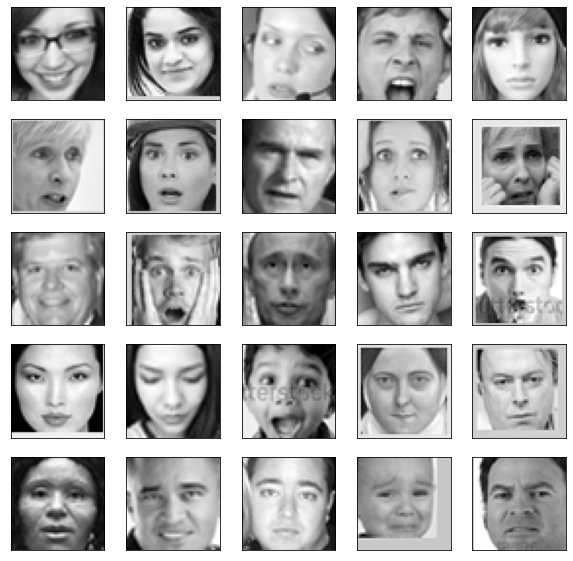

In [63]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap='gray')
plt.show()

Now we have seen our both the test data and train data, we will move to implement Conventional Machine learning model and Deep Learning model,to get the result and then compare the result of both the model and find the best approach for facial expression recognition.

# Conventional Model

Conventional machine learning model to train our data and predict output on the test data.

To implement Conventional Machine learnig first, the shape of image must be in 2-dimension.

Reshape function to change the dimension of the data. We apply reshape function on train data, test data.

In [6]:
#reshape is used to change the dimensional of the data from 1-dimension to 2-dimension
new_img = images_train.reshape(images_train.shape[0],(images_train.shape[1]*images_train.shape[2]))
new_img.shape

(9328, 2304)

In [7]:
#to change the shape of public test data
new_img_test = images_test_public.reshape(images_test_public.shape[0],(images_test_public.shape[1]*images_test_public.shape[2]))
new_img_test.shape

(1136, 2304)

## Data Splitting

Once the shape is changed, the other step is to split the data into training data and testing data.

train_test_split  function is used to split the image_train and labels_train data into training and testing dataset

It split the data in the ratio of 80% and 20%.80 percent is the size of the train data and 20 percent is the size of the test data

Random_state is used to randomly pick the data and split into train and test part.

In [65]:
X = new_img
y = labels_train
#train_test_split function is used to split the data into 80 and 20 ratio
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,random_state=142)
print(X_train.shape) #to print the shape of the data
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7462, 2304)
(1866, 2304)
(7462,)
(1866,)


## Random Forest Model

Random forest classifier is applied on the training dataset to predict the facial expression of the human image.

Random Forest is chosen because it is used in regression and classification prediction and our task is to predict the facial expression.

The other reason is that it classified the data very fast and it has high rememberance in big dimension data.

In [74]:
#Create a Gaussian Classifier
rfc=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(X_train,y_train)

y_prediction=rfc.predict(X_test)

In [75]:
print("Accuracy Score is :",accuracy_score(y_test, y_prediction)) #Accuray of test data

Accuracy Score is : 0.5364415862808146


The Model gave the accuracy of 53.64 percent which is quite low, so we applied next model to get better result.

## Support Vector Classifier

Random forest classifier gave us low accuracy so,we now applied a new model on our dataset to identify the human expression.

Support Vector Classifier is used  detecting facial expression from the images, it is a supervised learning algorthim which is capable of implementing classification and regression techniques.

In [11]:
#Create Support Vector Classifier
clf = svm.SVC(C=5)
#fit the training variable with the support vector classifier
clf.fit(X_train, y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Now we will apply our support vector algorithim to predict the facial expression of human image image on test data and calculate the accuracy.

In [12]:
y_pred=clf.predict(X_test) #predict facial expression of test data

In [13]:
print("Accuracy Score is :",accuracy_score(y_test, y_pred))

Accuracy Score is : 0.5659163987138264


In [14]:
print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, y_pred)
print(CR)
print('\n')



Precision, Recall, F1


              precision    recall  f1-score   support

           0       0.38      0.41      0.40       234
           1       0.75      0.52      0.61        29
           2       0.47      0.40      0.43       235
           3       0.69      0.79      0.74       546
           4       0.34      0.26      0.30       189
           5       0.73      0.62      0.67       218
           6       0.53      0.57      0.55       415

    accuracy                           0.57      1866
   macro avg       0.56      0.51      0.53      1866
weighted avg       0.56      0.57      0.56      1866





Support Vector gave the accuracy of 57% which pretty much high than the accuracy we obtained from Random Forest Classifier.

From the classification report, precission, recall and F1 score value can be identified which is pretty good, it clearly give us the impression of improvement.

In [70]:
from sklearn.metrics import confusion_matrix

confusionmatrix = confusion_matrix(y_test, y_pred)
confusionMatrix_df = pd.DataFrame(data = confusionmatrix, index=EMOTIONS, columns = EMOTIONS)

confusionMatrix_df

,angry,disgusted,fearful,happy,sad,surprised,neutral
angry,97,1,23,45,22,7,39
disgusted,2,15,1,7,0,1,3
fearful,26,3,93,28,21,20,44
happy,32,0,17,430,9,9,49
sad,39,1,16,24,49,6,54
surprised,6,0,20,33,4,135,20
neutral,50,0,28,54,38,8,237


Confusion matrix can tell us misclassified classes in our model, so confusion matrix is applied so that we can find out the missclassified class in our data.

In this confusion matrix, diagonal values represent the class are correct classified whereas the non-diagonal value represents the missclassified value in the other labels.

So, if we consider angry, 2 angry images are classified as disgusted similarly we can see the other ones.


In [16]:
y_prediction_test=clf.predict(new_img_test) #predict the labels of image test data
print(y_prediction_test)

[3 4 2 ... 5 3 6]


In [17]:
import pandas as pd
image_model_predict_df=pd.DataFrame(y_prediction_test,columns=['prediction'])

In [18]:
image_model_predict_df.to_csv("s3://mlproject-major/facial-expression-recognition/image_model_predict_df.csv") #load the CSV file into local system

If we compare both the model we find that accuracy obtained from Random Forest is 53 percent which is quite low,random forest model just crossed the base line of 50 percent accuracy which cannot be considered as a good model. 

We applied support vector machine learning classifier on our training data set, in which we got the accuracy of 57% which not good but it is better than random forest classifier but we cannot take this model as our final model for human facial expression prediction.So, now we move towards Deep learning model to get some better accuracy.

## Notes on Conventional Model

If the choice is to pick the best model from convemtional learning model, then support vector classifier would be the best as it gives the accuracy 0.57 on a small data set which is better than any other conventional machine learning model.

If we also see the Precision, Recall ,F1 score and accuracy score in the accuracy report then it gives us the positive feedback.

So, according to my point of view, SVM is better Conventional Machine learning model for facial expression recognition.

# Deep Learning Model

The final model that gives the best accuracy of 63.56 for the Kaggle submission  was a fully connected dense model with 6 layers.The input is the raw image that is process by our model. 

Different type of techniques is applied to implement Convolutional Neural network.some of the are explained below.

## Data PreProcessing

Deep learning model can only be implemented on 3 or more dimension data set.

Resize function used to change the dimension of the data.

img_resize function is created so that it changes dimension of test and train image data.

In [3]:
def img_resize(inp):#image resize function
    img=Image.fromarray(inp*255)#Convert the image of 1 dimension into 3 dimension
    return np.asarray(img)

In [4]:
#loop is run of the train and test image data to convert into 3 dimension
images_train_resize = np.array([img_resize(i) for i in images_train])
images_test_resize = np.array([img_resize(i) for i in images_test_public])

print(images_train_resize.shape,images_test_resize.shape)

(9328, 48, 48) (1136, 48, 48)


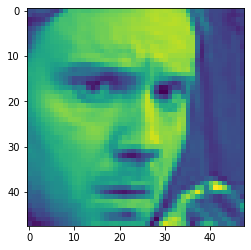

In [21]:
#plot the first image of the train data
plt.imshow(images_train_resize[0])

In [5]:
#expand dimension is used to change the 3 dimension image into 4 dimension
images_train_resize = np.expand_dims(images_train_resize, axis=3)#numpy function to change 3-dimension to 4 dimension
images_test_resize = np.expand_dims(images_test_resize, axis=3)
print(images_train_resize.shape,images_test_resize.shape)

(9328, 48, 48, 1) (1136, 48, 48, 1)


In [6]:
# keras.utils.to_categorical convert the labels data into two dimension
labels_train1= keras.utils.to_categorical(labels_train)
print(labels_train1.shape)

(9328, 7)


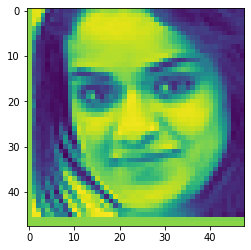

In [24]:
#plot the image test data
plt.imshow(images_test_public[1])

In [9]:
#store the unique labels into the variable a
a=len(np.unique(labels_train))
print(a)

7


## Data Split in deep learning

We again applied train test_split function to split the data so that we can apply conventional machine learning model on them. 

Previous training and testing data is in 2 dimension and 3 or 4-dimension data in needed for deep learning model implementation. The other reason is now we split the data into train, test and validation set.

Train set contains the train data,validation set contains the validate data i.e. the data used with the training data in prediction and testing set contains the testing data to verify the model we have created give the correct output.

We divide our data into 73 percent, 15 percent and 12 percent, where 73 percent is train dataset, 15 percent is for validation data set and 12 is test  data set

In [7]:
#split the data into train and validtion data set
x_train1,x_val,y_train1,y_val=train_test_split(images_train_resize,labels_train1,test_size=0.15,random_state=142)
print(x_train1.shape,x_val.shape,y_train1.shape,y_val.shape)

(7928, 48, 48, 1) (1400, 48, 48, 1) (7928, 7) (1400, 7)


In [8]:
#split train data set is again split into train and test dataset
x_train,x_test,y_train,y_test=train_test_split(x_train1,y_train1,test_size=0.15,random_state=142)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(6738, 48, 48, 1) (1190, 48, 48, 1) (6738, 7) (1190, 7)


To get the better accuracy for our model,data must be analyze at granular level. 

So, the first task is to find out the number of images in each label, this will tell us whether the data is equally divided or not.

# Class balance

In [28]:
#store the data into list based on the unique labels
value_0=[]
value_1=[]
value_2=[]
value_3=[]
value_4=[]
value_5=[]
value_6=[]
#run the loop on each label class data, so to store the data based on the label
for i ,j in enumerate(labels_train): 
    if labels_train[i]==0:
        value_0.append(labels_train[i])
valuefor_0=len(value_0)
for i ,j in enumerate(labels_train):
    if labels_train[i]==1:
        value_1.append(labels_train[i])
valuefor_1=len(value_1)
for i ,j in enumerate(labels_train):
    if labels_train[i]==2:
        value_2.append(labels_train[i])
valuefor_2=len(value_2)
for i ,j in enumerate(labels_train):
    if labels_train[i]==3:
        value_3.append(labels_train[i])
valuefor_3=len(value_3)
for i ,j in enumerate(labels_train):
    if labels_train[i]==4:
        value_4.append(labels_train[i])
valuefor_4=len(value_4)
for i ,j in enumerate(labels_train):
    if labels_train[i]==5:
        value_5.append(labels_train[i])
valuefor_5=len(value_5)
for i ,j in enumerate(labels_train):
    if labels_train[i]==6:
        value_6.append(labels_train[i])
valuefor_6=len(value_6)

#display the number of images in each class
print('number of images in labels 0:',valuefor_0)
print('number of images in labels 1:',valuefor_1)
print('number of images in labels 2:',valuefor_2)
print('number of images in labels 3:',valuefor_3)
print('number of images in labels 4:',valuefor_4)
print('number of images in labels 5:',valuefor_5)
print('number of images in labels 6:',valuefor_6)

number of images in labels 0: 1266
number of images in labels 1: 211
number of images in labels 2: 1107
number of images in labels 3: 2736
number of images in labels 4: 1043
number of images in labels 5: 1052
number of images in labels 6: 1913


Above output indicate that the each label do not have equal number of images,so we tried to now we balanced the weight on each class label, so that overfitting issue does not arises.

In [29]:
#Calculate weight of each label class
weight_for_0 = (1/valuefor_0 )*(len(labels_train))/7.0 
weight_for_1 = (1/valuefor_1)*(len(labels_train))/7.0
weight_for_2 = (1/valuefor_2)*(len(labels_train))/7.0
weight_for_3 = (1/valuefor_3)*(len(labels_train))/7.0
weight_for_4 = (1/valuefor_4)*(len(labels_train))/7.0
weight_for_5 = (1/valuefor_5)*(len(labels_train))/7.0
weight_for_6 = (1/valuefor_6)*(len(labels_train))/7.0

#store the label class in the data dictionary
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5, 6: weight_for_6}

#display the weight of each class
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 1: {:.2f}'.format(weight_for_2))
print('Weight for class 1: {:.2f}'.format(weight_for_3))
print('Weight for class 1: {:.2f}'.format(weight_for_4))
print('Weight for class 1: {:.2f}'.format(weight_for_5))
print('Weight for class 1: {:.2f}'.format(weight_for_6))

Weight for class 0: 1.05
Weight for class 1: 6.32
Weight for class 1: 1.20
Weight for class 1: 0.49
Weight for class 1: 1.28
Weight for class 1: 1.27
Weight for class 1: 0.70


## First Model

Once,the weight of the class is balanced,then convolutional neural network with 4 blocks of Convolution2D layer and 2 blocks of fully connected layer is applied.


Convolutional neural network is chosen as it is best in visualizing the image data.It is the most common algorithm used in predicting the facial expression.

Our model also has relu activation function and MaxPooling2D and BatchNormalization.


In [30]:
# build the network
CNN_model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

#block1
CNN_model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))#conv2D means the input data is in 3-dimension
CNN_model.add(Activation('relu')) #rectified linear activation for efficient result
CNN_model.add(MaxPooling2D(pool_size=(2, 2))) #to calculate largest of the labels
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.25)) # to reduce overfitting issue

#block2
CNN_model.add(Conv2D(64, (3, 3)))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2))) # to calculate the maximum value based on each label
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.25))

#block3
CNN_model.add(Conv2D(64, (3, 3)))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.25))
  
#block4
CNN_model.add(Conv2D(64, (3, 3)))
CNN_model.add(Activation('relu'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.25)) 


#block 5
CNN_model.add(Flatten()) #the layer will convert 3-dimension into the single vector
CNN_model.add(Dense(256, activation='relu'))
CNN_model.add(Dropout(0.25))

#BLock 6
CNN_model.add(Dense(256, activation='relu')) #fully connected layer that will give the total output
CNN_model.add(Dropout(0.25))
CNN_model.add(Dense(a, activation='softmax'))# to round off the output value to 0 and 1 

CNN_model.summary()


Input dimensions:  (48, 48, 1)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)   

Model checkpoint is used so to store the best accuracy obtained from the epoch, it store the model in the XML file and then this model can be applied for test data prediction.

In [31]:
from keras.callbacks import ModelCheckpoint
CNNcheckpoint = ModelCheckpoint(filepath="face_recog_imbalance.xml", #store the model in the Xml file
                             monitor="val_acc", # monitor validation accuray
                             mode="max",
                             save_best_only=True,#store only best accuracy
                             verbose=1)
callbacks = [CNNcheckpoint]
print(callbacks)

In [32]:
# compile the model to use categorical cross-entropy loss function and adam optimizer
CNN_model.compile(loss='categorical_crossentropy' ,
              optimizer='adam',
              metrics=['accuracy'])

history = CNN_model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=30,
                    class_weight=class_weight,
                    callbacks=callbacks,
                    validation_data=(x_val, y_val))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6738 samples, validate on 1400 samples
Epoch 1/30
6738/6738 [==============================] - 11s 2ms/step - loss: 2.0084 - acc: 0.1791 - val_loss: 1.8562 - val_acc: 0.2579

Epoch 00001: val_acc improved from -inf to 0.25786, saving model to face_recog_imbalance.xml
Epoch 2/30
6738/6738 [==============================] - 6s 957us/step - loss: 1.9031 - acc: 0.2300 - val_loss: 1.9144 - val_acc: 0.1607

Epoch 00002: val_acc did not improve from 0.25786
Epoch 3/30
6738/6738 [==============================] - 6s 916us/step - loss: 1.8030 - acc: 0.2720 - val_loss: 1.7754 - val_acc: 0.2707

Epoch 00003: val_acc improved from 0.25786 to 0.27071, saving model to face_recog_imbalance.xml
Epoch 4/30
6738/6738 [==============================] - 6s 919us/step - loss: 1.7451 - acc: 0.3133 - val_loss: 1.5767 - val_acc: 0.3821

Epoch 00004: val_acc improved from 0.27071 to 0.38214, saving model 

In [33]:
CNN_model=keras.models.load_model('face_recog_imbalance.xml') #to load the model for prediction

In [34]:
#Calculate the accuracy of the test data
loss, accuracy = CNN_model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.0965738671166556
Test accuracy: 0.5974789914964628


From the above model, it is visible that the overfitting issue is prevented but accuracy is not getting better, our accuracy is only 59 percent which cannot be taken as a good result.

## Second Model 

Second convolution model contains 4 blocks of convolutional layer and 2 fully connected layer, but now selu function is used instead with Maxpooling2d Fucntion, batch normalization and Drop out fucntion with a value of 0.25

selu is the self normalising linear units which automatically normalized the data

In [35]:
# build the network
model = Sequential() #sequential layer is to use the output of one layer as the input of other in the sequential order 
print("Input dimensions: ",x_train.shape[1:]) #input the dimension

#block 1
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:])) #convolution layer of size 32 with kernel size 3,3
model.add(Activation('selu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # to calculate the maximum value based on each label
model.add(BatchNormalization()) 
model.add(Dropout(0.25)) # to reduce the overfitting effect in the model

#block 2
model.add(Conv2D(64, (3, 3)))
model.add(Activation('selu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())#it is normalize the input layer to prevent shift problem
model.add(Dropout(0.25))

#block 3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('selu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
 
#block 4
model.add(Conv2D(128, (3, 3)))
model.add(Activation('selu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

#Block 5
model.add(Flatten())
model.add(Dense(256, activation='selu')) # it is to take input layer and implement selu function and return the output
model.add(Dropout(0.25))

#block 6
model.add(Dense(512, activation='selu'))
model.add(Dropout(0.25))
model.add(Dense(a, activation='softmax')) # to round off the output value to 0 and 1 

model.summary()

Input dimensions:  (48, 48, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 23, 23, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_6 (Activation)    (None, 21, 21, 6

Model check point is created to store the best accuracy of the model so to find the accuracy of the test data

In [36]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath="face_recog_new.xml", #store the model in the Xml file
                             monitor="val_acc", # monitor validation accuray
                             mode="max",
                             save_best_only=True,#store only best accuracy
                             verbose=1)
callbacks = [checkpoint]
print(callbacks)

In model compilation categorical_crossentropy is used as loss as the data is categorical data,

Optimizer is adam because it is fast and efficient optimizer that can give the best result but it has a drawback, that is show less effective convergence  which means if we trained our data for longer then adam does not give better convergence of data.

In [37]:
# compile the model to use categorical cross-entropy loss function and adam optimizer
model.compile(loss='categorical_crossentropy' ,
              optimizer='adam',
              metrics=['accuracy'])

#Use Fit function to fit our model with the validation data
history = model.fit(x_train,y_train, 
                    batch_size=128, #to fit 128 images at one time and find the accuracy
                    epochs=30, #run the model in a 30 round
                    callbacks=callbacks,
                    validation_data=(x_val,y_val))

Train on 6738 samples, validate on 1400 samples
Epoch 1/30
6738/6738 [==============================] - 23s 3ms/step - loss: 2.1567 - acc: 0.2591 - val_loss: 2.3007 - val_acc: 0.3121

Epoch 00001: val_acc improved from -inf to 0.31214, saving model to face_recog_new.xml
Epoch 2/30
6738/6738 [==============================] - 18s 3ms/step - loss: 1.8071 - acc: 0.3476 - val_loss: 1.8020 - val_acc: 0.3586

Epoch 00002: val_acc improved from 0.31214 to 0.35857, saving model to face_recog_new.xml
Epoch 3/30
6738/6738 [==============================] - 18s 3ms/step - loss: 1.6490 - acc: 0.4114 - val_loss: 1.6552 - val_acc: 0.4157

Epoch 00003: val_acc improved from 0.35857 to 0.41571, saving model to face_recog_new.xml
Epoch 4/30
6738/6738 [==============================] - 18s 3ms/step - loss: 1.5506 - acc: 0.4433 - val_loss: 1.7115 - val_acc: 0.4557

Epoch 00004: val_acc improved from 0.41571 to 0.45571, saving model to face_recog_new.xml
Epoch 5/30
6738/6738 [=============================

In [38]:
model=keras.models.load_model('face_recog_new.xml') #load the model with the best accuracy

In [39]:
#Calculate the accuracy of the test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.0924153550332334
Test accuracy: 0.6109243698480751


The second CNN Model give us the accuray of 61 percent which is better than our first CNN model. We can further improve our accuracy by applying some other techniques in the CNN model.

In [40]:
ouput1=model.predict_classes(images_test_resize) #predicting facial expression of test data
print(ouput1)

[3 3 2 ... 3 3 6]


Although accuracy of our data is improved, now the accuracy is 61 which is 5 percent more than conventional machine learning model and 3 percent better from our first CNN model.

## Third Model

Third deep learning model contains relu function, MaxPooling 2d and batch normalization, it also has padding and strides.

Strides denotes the number of steps move in each convolution and padding is used to increase the width and height of output image

This Model also has different compilation, now we have used SGD and alsospecifies the value of decay,momentum.

In [18]:
# build the network
model1 = Sequential()
print("Input dimensions: ",x_train.shape[1:])

#block1
model1.add(Conv2D(64, (3, 3), input_shape=x_train.shape[1:])) #input training data
model1.add(Activation('relu')) # rectified linear activation
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.25)) #to reduce the overfitting issue

#strides to increase the number of steps in each layer and padding is to increase heigh and width

#block 2
model1.add(Conv2D(64,(3,3), activation='relu',padding='same', strides=(1, 1)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

#block 3
model1.add(Conv2D(64,(3,3), activation='relu',padding='same', strides=(1, 1)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

#block 4
model1.add(Conv2D(128,(3,3), activation='relu',padding='same', strides=(1, 1)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

#block 5
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.25))

#block 6
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(a, activation='softmax'))

model1.summary()

Input dimensions:  (48, 48, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 11, 6

ModelCheckpoint is created to store the best accuracy of the model of the validation data and then applied in model prediction

In [19]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath="face_recognition_one.xml", #to store model in the xml file
                             monitor="val_acc", # monitoring validation accuracy
                             mode="max",
                             save_best_only=True, #store best accuracy 
                             verbose=1)
callbacks = [checkpoint]
print(callbacks)

SGD is the stochastic gradient descent used in the classical optimization, it's learning rate value is 0.02 which tells that the model will learn at the rate of 0.02, 
nestrov is set to true so to classify the image, momentum is set to 0.8 so it accelerates the gradient descent in the relevant direction, decay is used to decrease the learning rate over each update.

In [20]:
opt = keras.optimizers.SGD(lr=0.02,decay=1e-4, momentum=0.8, nesterov=True)
model1.compile(optimizer= opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [21]:
history = model1.fit(x_train,y_train,
                    batch_size=128,
                    epochs=40,
                    callbacks=callbacks,
                    validation_data=(x_test,y_test))

Train on 6738 samples, validate on 1190 samples
Epoch 1/40
6738/6738 [==============================] - 15s 2ms/step - loss: 1.9044 - acc: 0.2722 - val_loss: 1.7010 - val_acc: 0.3277

Epoch 00001: val_acc improved from -inf to 0.32773, saving model to face_recognition_one.xml
Epoch 2/40
6738/6738 [==============================] - 10s 2ms/step - loss: 1.7613 - acc: 0.3112 - val_loss: 1.6558 - val_acc: 0.3630

Epoch 00002: val_acc improved from 0.32773 to 0.36303, saving model to face_recognition_one.xml
Epoch 3/40
6738/6738 [==============================] - 10s 1ms/step - loss: 1.6521 - acc: 0.3627 - val_loss: 1.5343 - val_acc: 0.4151

Epoch 00003: val_acc improved from 0.36303 to 0.41513, saving model to face_recognition_one.xml
Epoch 4/40
6738/6738 [==============================] - 10s 1ms/step - loss: 1.5702 - acc: 0.4124 - val_loss: 1.4719 - val_acc: 0.4647

Epoch 00004: val_acc improved from 0.41513 to 0.46471, saving model to face_recognition_one.xml
Epoch 5/40
6738/6738 [=====

In [22]:
model1=keras.models.load_model('face_recognition_one.xml')

In [23]:
loss, accuracy = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.0802264255635878
Test accuracy: 0.6352941175468829


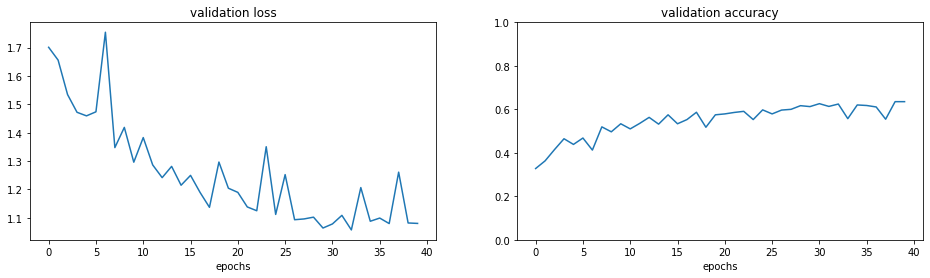

In [24]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

The third model gives the accuracy of 0.635 percent on Train data set  which is far better than the accuracy of the previous two CNN model and convolutional machine learning model. 

We can also see that there is not much difference between the validation accuracy and testing accuracy which states that our model is not over fitting and can be used in future also.

The third interpretaion is the validation accuray is increased on every epoch which give the positive impact on our prediction.

# Best Accuracy

In [25]:
from prettytable import PrettyTable
x = PrettyTable()
print('\n')
print("Models.")
x.field_names = ["Models", "Accuracy"]
x.add_row(["RandomForestClassifier", 0.5364])
x.add_row(["SVM", 0.57])
x.add_row(["CNN with class weight balancing ", 0.59])
x.add_row(["CNN with selu ", 0.619])
x.add_row(["CNN with relu and Padding and strides ", 0.635])
print(x)
print('\n')



Models.
+----------------------------------------+----------+
|                 Models                 | Accuracy |
+----------------------------------------+----------+
|         RandomForestClassifier         |  0.5364  |
|                  SVM                   |   0.57   |
|    CNN with class weight balancing     |   0.59   |
|             CNN with selu              |  0.619   |
| CNN with relu and Padding and strides  |  0.635   |
+----------------------------------------+----------+




So, third CNN model is applied on private test dataset and public test data set for the kaggle submission and their accuracy is recorded.

## Public Test data prediction

In [26]:
public_ouput=model1.predict_classes(images_test_resize) #predicting facial expression of test data
print(public_ouput)

[3 3 4 ... 6 3 6]


In [27]:
import pandas as pd
Public_image_model_predict_df=pd.DataFrame(public_ouput,columns=['prediction'])

In [28]:
Public_image_model_predict_df.to_csv("s3://mlproject-major/facial-expression-recognition/Public_image_model_predict_df.csv") #load the CSV file into local system

## Private test data Prediction

Private dataset is the new dataset contains image data, it has 1153 rows and it is one dimension, so again we reshape the data using img_resize function and then applied third CNN model on it.

In [29]:
from PIL import Image
privateimages_test_resize = np.array([img_resize(i) for i in images_test_private])

In [30]:
privateimages_test_resize = np.expand_dims(privateimages_test_resize, axis=3)

In [31]:
ouput1=model1.predict_classes(privateimages_test_resize) #predicting facial expression of test data
print(ouput1)

[4 5 3 ... 6 3 2]


In [32]:
#store the output in the csv file with the unique ID and the prediction value
Public_image_model_predict_df.to_csv("s3://mlproject-major/facial-expression-recognition/46153640-CNN.csv") #load the CSV file into local system

# Discussion 

Above, we had implemented both Conventional learning model and deep learning to predict the facial recorgnition of the human images.
From the conventional learning model, SVM is best which gave the accuracy of 57 percent on train data set, but the accuracy gets reduced to 55 percent on the test data set which states that this model is not best for facial recorgnition.

From the deep learning model, we get the accuracy of 61 percent on public test data set from our second deep learning model, the accuracy improved but when we submit the data on kaggle, we got 60 percent which clearly state that it might be overfitting issue.

But the 3 third CNN model gave the accuracy of 0.63529 percent on train data  and accuracy of 63.56 percent on the private test data set and 60 percent on the public test data set, our accuracy is improved but for the private dataset only and data is not much overfitting but still we do not get better accuracy for train dataset. 

The reason for not getting higher accurary is can be the small size of data or we should have used some pre-trained model to predict the face features from the images.

# References

For Amazon sazemaker:Connect jupyter notebook to load the data

https://stackoverflow.com/questions/48264656/load-s3-data-into-aws-sagemaker-notebook

For human Facial recorgnition

https://medium.com/@abhayakumar169/facial-expression-recognition-cf6a61f8045f

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8698067&tag=1
